In [4]:
# Dataset: CIFAR-10

# Combine PCA and KMeans to classify images

# KMeans is an unsupervised clustering method. -> Only use the test dataset

# Define the batch size for training and testing

from tqdm import tqdm

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# 1. Load all test images
    # Convert to numpy array
    # Flattend 2D images to 1D vectors
        # -> Obtain a feature matrix of shape (10000, 3072)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1).numpy())
])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)
print(f"Number of test images: {len(test_dataset)}")
test_images = np.array([test_dataset[i][0] for i in range(len(test_dataset))])
test_labels = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
print(f"Shape of test images: {test_images.shape}")
print(f"Shape of test labels: {test_labels.shape}")

# 2. Normalize features to be zero-mean, unit standard deviation (refer to here)
mean = np.mean(test_images, axis=0)
std = np.std(test_images, axis=0)
test_images = (test_images - mean) / std
print(f"Shape of normalized test images: {test_images.shape}")

# 3. Use PCA to reduce the feature dimension from 3072 to 5
pca = PCA(n_components=5)
pca.fit(test_images)
test_images_pca = pca.transform(test_images)
print(f"Shape of PCA-reduced test images: {test_images_pca.shape}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# 4. Use kMeans to cluster the features from PCA. 
    # Use kMeans from scikit-learn
    # Use 10 clusters (k=10) and random_state=0
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(test_images_pca)
predicted_clusters = kmeans.predict(test_images_pca)
print(f"Shape of predicted clusters: {predicted_clusters.shape}")
print(f"Predicted clusters: {np.unique(predicted_clusters)}")
print(f"Cluster centers: {kmeans.cluster_centers_}")
print(f"Cluster labels: {kmeans.labels_}")


# 5. Use the following purity metric:
def purity_score(predicted_clusters, labels):
    # predicted_clusters: 1D array of assigned cluster ID, produced by KMeans
    # labels: 1D array of groundtruth class labels.
    cluster_map = {}
    for i, cluster in enumerate(predicted_clusters):
        if cluster not in cluster_map:
            cluster_map[cluster] = {}
        lbl = labels[i].item()
        cluster_map[cluster][lbl] = cluster_map[cluster].get(lbl, 0) + 1

    cluster_to_label = {}

    for cluster, freq_dict in cluster_map.items():
        cluster_to_label[cluster] = max(freq_dict, key=freq_dict.get)

    correct = 0
    for i, cluster in enumerate(predicted_clusters):
        if labels[i].item() == cluster_to_label[cluster]:
            correct += 1
            
    accuracy = correct / len(labels)
    return accuracy

print(f"Purity score: {purity_score(predicted_clusters, test_labels)}")


Number of test images: 10000
Shape of test images: (10000, 3072)
Shape of test labels: (10000,)
Shape of normalized test images: (10000, 3072)
Shape of PCA-reduced test images: (10000, 5)
Explained variance ratio: [0.2699821  0.11051764 0.07353128 0.03817558 0.03601289]
Shape of predicted clusters: (10000,)
Predicted clusters: [0 1 2 3 4 5 6 7 8 9]
Cluster centers: [[ 3.1175797e+00 -2.6187342e+01 -2.6468866e+00 -1.1362144e+00
  -2.2588356e+00]
 [-1.6521187e+01  3.4720352e-01  1.8066986e+01 -8.0627054e-01
  -9.4613230e-01]
 [ 3.2064201e+01 -2.1783911e+01  9.8383713e+00  7.2691077e-01
   2.9512694e-01]
 [ 6.0191879e+01  1.4213691e+01  1.3047000e+00 -2.8871067e-02
   4.0260482e-01]
 [-4.7365009e+01  3.4033018e-01  1.2465121e-01 -1.9027030e+00
  -1.3734385e+00]
 [-1.3541911e+01  2.7643919e+01 -2.9801228e+00  2.4506857e-01
  -1.1865757e+00]
 [-2.1322170e+01 -4.8201599e+00 -8.8483162e+00  2.1984177e+00
   1.7619090e+00]
 [ 2.6625803e+01  3.7790604e+00 -1.9776718e+01 -1.2564313e+00
  -1.43712

100%|██████████| 5/5 [00:12<00:00,  2.43s/it]

Purity scores: [0.2169, 0.2151, 0.2217, 0.2187, 0.2114]


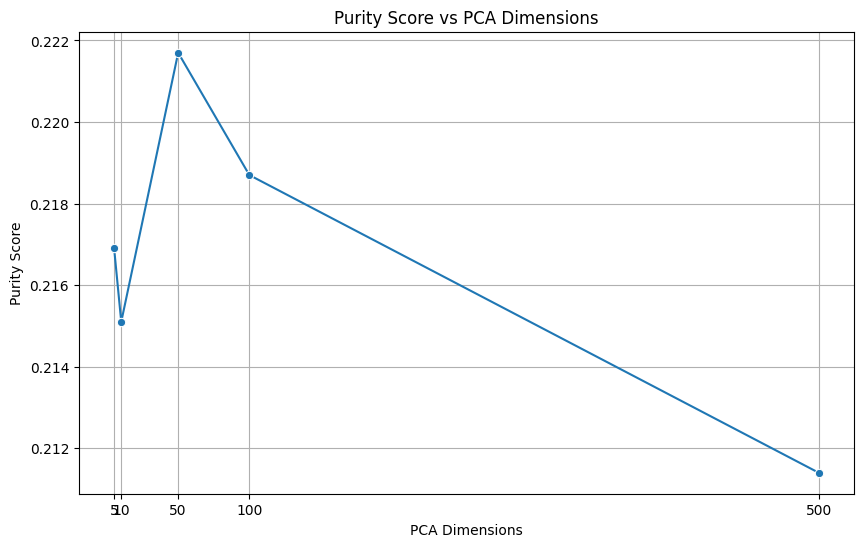

In [5]:
# perform the same for different dimensions for PCA dimensions = [5,10,50,100,500]
# and plot the purity score against the PCA dimensions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


pca_dimensions = [5, 10, 50, 100, 500]
purity_scores = []

for dim in tqdm(pca_dimensions):
    pca = PCA(n_components=dim)
    pca.fit(test_images)
    test_images_pca = pca.transform(test_images)
    kmeans = KMeans(n_clusters=10, random_state=0)
    kmeans.fit(test_images_pca)
    predicted_clusters = kmeans.predict(test_images_pca)
    purity_scores.append(purity_score(predicted_clusters, test_labels))

print(f"Purity scores: {purity_scores}")

# a plot of purity score against PCA dimensions
plt.figure(figsize=(10, 6))
sns.lineplot(x=pca_dimensions, y=purity_scores, marker='o')
plt.title('Purity Score vs PCA Dimensions')
plt.xlabel('PCA Dimensions')
plt.ylabel('Purity Score')
plt.xticks(pca_dimensions)
plt.grid()
plt.show()